#Recurrent Neural Networks

Sequences. Depending on your background you might be wondering: What makes Recurrent Networks so special? A glaring limitation of Vanilla Neural Networks (and also Convolutional Networks) is that their API is too constrained: they accept a fixed-sized vector as input (e.g. an image) and produce a fixed-sized vector as output (e.g. probabilities of different classes). Not only that: These models perform this mapping using a fixed amount of computational steps (e.g. the number of layers in the model). The core reason that recurrent nets are more exciting is that they allow us to operate over sequences of vectors: Sequences in the input, the output, or in the most general case both. A few examples may make this more concrete:

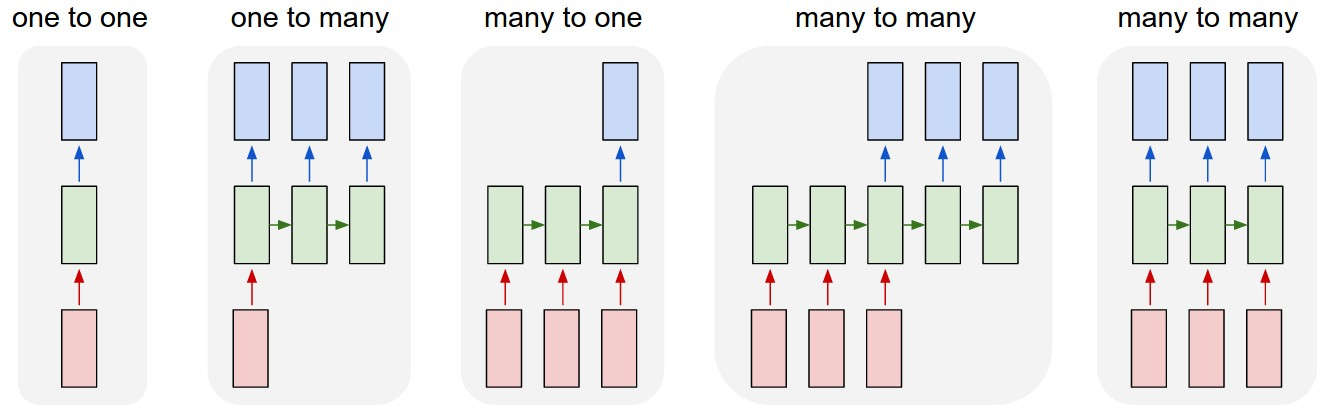

Each rectangle is a vector and arrows represent functions (e.g. matrix multiply). Input vectors are in red, output vectors are in blue and green vectors hold the RNN's state (more on this soon). From left to right: (1) Vanilla mode of processing without RNN, from fixed-sized input to fixed-sized output (e.g. image classification). (2) Sequence output (e.g. image captioning takes an image and outputs a sentence of words). (3) Sequence input (e.g. sentiment analysis where a given sentence is classified as expressing positive or negative sentiment). (4) Sequence input and sequence output (e.g. Machine Translation: an RNN reads a sentence in English and then outputs a sentence in French). (5) Synced sequence input and output (e.g. video classification where we wish to label each frame of the video). Notice that in every case are no pre-specified constraints on the lengths sequences because the recurrent transformation (green) is fixed and can be applied as many times as we like.




Sequential processing in absence of sequences. You might be thinking that having sequences as inputs or outputs could be relatively rare, but an important point to realize is that even if your inputs/outputs are fixed vectors, it is still possible to use this powerful formalism to process them in a sequential manner. For instance, the figure below shows results from two very nice papers from DeepMind. On the left, an algorithm learns a recurrent network policy that steers its attention around an image; In particular, it learns to read out house numbers from left to right (Ba et al.). On the right, a recurrent network generates images of digits by learning to sequentially add color to a canvas (Gregor et al.):





<img src="house_read.gif" style="zoom:50%"  >
<img src="house_generate.gif"  align="center" >

from IPython.display import Image

gif_path = "house_generate.gif"

display(Image(filename=gif_path))



import matplotlib.pyplot as plt

import matplotlib.image as mpimg

img = mpimg.imread("house_read.gif")

plt.imshow(img)

gif_path = "house_generate.gif"
display(Image(data=open(gif_path,'rb').read(), format='png'))
import base64
b64 = base64.b64encode(open(gif_path,'rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))

RNN computation. So how do these things work? At the core, RNNs have a deceptively simple API: They accept an input vector x and give you an output vector y. However, crucially this output vector’s contents are influenced not only by the input you just fed in, but also on the entire history of inputs you’ve fed in in the past. Written as a class, the RNN’s API consists of a single step function:

rnn = RNN()

y = rnn.step(x) 

#x is an input vector, y is the RNN's output vector
The RNN class has some internal state that it gets to update every time step is called. In the simplest case this state consists of a single hidden vector h. Here is an implementation of the step function in a Vanilla RNN:

class RNN:
  
  def step(self, x):
  
    # update the hidden state
    self.h = np.tanh(np.dot(self.W_hh, self.h) + np.dot(self.W_xh, x))
    # compute the output vector
    y = np.dot(self.W_hy, self.h)
    return y
    
The above specifies the forward pass of a vanilla RNN. This RNN’s parameters are the three matrices W_hh, W_xh, W_hy. The hidden state self.h is initialized with the zero vector. The np.tanh function implements a non-linearity that squashes the activations to the range [-1, 1]. Notice briefly how this works: There are two terms inside of the tanh: one is based on the previous hidden state and one is based on the current input. In numpy np.dot is matrix multiplication. The two intermediates interact with addition, and then get squashed by the tanh into the new state vector. If you’re more comfortable with math notation, we can also write the hidden state update as $h_t=tanh(W_{hh}h_{t−1}+W_{xh}x_t)$ , where tanh is applied elementwise.




# Practice: Classifying Names with a Character-Level RNN

We will be building and training a basic character-level RNN to classify words. A character-level RNN reads words as a series of characters - outputting a prediction and "hidden state" at each step, feeding its previous hidden state into each next step. We take the final prediction to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages of origin, and predict which language a name is from based on the spelling:

```
$ python predict.py Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish

$ python predict.py Schmidhuber
(-0.19) German
(-2.48) Czech
(-2.68) Dutch
```

# Recommended Reading


* http://pytorch.org/ For installation instructions
* [Deep Learning with PyTorch: A 60-minute Blitz](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) to get started with PyTorch in general
* [jcjohnson's PyTorch examples](https://github.com/jcjohnson/pytorch-examples) for an in depth overview
* [Introduction to PyTorch for former Torchies](https://github.com/pytorch/tutorials/blob/master/Introduction%20to%20PyTorch%20for%20former%20Torchies.ipynb) if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

* [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) shows a bunch of real life examples
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) is about LSTMs specifically but also informative about RNNs in general

# Preparing the Data

Included in the `data/names` directory are 18 text files named as "[Language].txt". Each file contains a bunch of names, one name per line, mostly romanized (but we still need to convert from Unicode to ASCII).

We'll end up with a dictionary of lists of names per language, `{language: [names ...]}`. The generic variables "category" and "line" (for language and name in our case) are used for later extensibility.

In [17]:
import glob
import os
#all_filenames = glob.glob(r'../data/names/*.txt')
all_filenames = glob.glob(os.path.join( 'names', '*.txt'))
print(all_filenames)

['names\\Arabic.txt', 'names\\Chinese.txt', 'names\\Czech.txt', 'names\\Dutch.txt', 'names\\English.txt', 'names\\French.txt', 'names\\German.txt', 'names\\Greek.txt', 'names\\Irish.txt', 'names\\Italian.txt', 'names\\Japanese.txt', 'names\\Korean.txt', 'names\\Polish.txt', 'names\\Portuguese.txt', 'names\\Russian.txt', 'names\\Scottish.txt', 'names\\Spanish.txt', 'names\\Vietnamese.txt']


In [18]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)


# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_to_ascii('Ślusàrski'))

Slusarski


In [19]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename).read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

for filename in all_filenames:
    category = filename.split('\\')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print('n_categories =', n_categories)
print(all_categories)

n_categories = 18
['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


Now we have `category_lines`, a dictionary mapping each category (language) to a list of lines (names). We also kept track of `all_categories` (just a list of languages) and `n_categories` for later reference.

In [20]:
#print(category_lines)
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


# Turning Names into Tensors

Now that we have all the names organized, we need to turn them into Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size `<1 x n_letters>`. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. `"b" = <0 1 0 0 0 ...>`.

To make a word we join a bunch of those into a 2D matrix `<line_length x 1 x n_letters>`.

That extra 1 dimension is because PyTorch assumes everything is in batches - we're just using a batch size of 1 here.

In [21]:
import torch

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    letter_index = all_letters.find(letter)
    tensor[0][letter_index] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        letter_index = all_letters.find(letter)
        tensor[li][0][letter_index] = 1
    return tensor

In [22]:
print(letter_to_tensor('J'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


In [23]:
print(line_to_tensor('Jones').size())
print(line_to_tensor('Lisbeth').size())

torch.Size([5, 1, 57])
torch.Size([7, 1, 57])


# Creating the Network

Before autograd, creating a recurrent neural network in Torch involved cloning the parameters of a layer over several timesteps. The layers held hidden state and gradients which are now entirely handled by the graph itself. This means you can implement a RNN in a very "pure" way, as regular feed-forward layers.

This RNN module (mostly copied from [the PyTorch for Torch users tutorial](https://github.com/pytorch/tutorials/blob/master/Introduction%20to%20PyTorch%20for%20former%20Torchies.ipynb)) is just 2 linear layers which operate on an input and hidden state, with a LogSoftmax layer after the output.

![](https://i.imgur.com/Z2xbySO.png)

In [24]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

## Manually testing the network

With our custom `RNN` class defined, we can create a new instance:

In [25]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We'll get back the output (probability of each language) and a next hidden state (which we keep for the next step).

Remember that PyTorch modules operate on Variables rather than straight up Tensors.

In [26]:
input = Variable(letter_to_tensor('A'))
hidden = rnn.init_hidden()

output, next_hidden = rnn(input, hidden)
print('output.size =', output.size())

output.size = torch.Size([1, 18])


For the sake of efficiency we don't want to be creating a new Tensor for every step, so we will use `line_to_tensor` instead of `letter_to_tensor` and use slices. This could be further optimized by pre-computing batches of Tensors.

In [27]:
input = Variable(line_to_tensor('Albert'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9684, -2.8151, -2.8812, -2.8813, -2.8197, -2.8890, -2.9258, -2.8679,
         -3.0001, -2.8401, -2.9695, -2.7742, -2.9303, -2.9558, -2.8941, -2.9179,
         -2.9151, -2.8144]], grad_fn=<LogSoftmaxBackward0>)


As you can see the output is a `<1 x n_categories>` Tensor, where every item is the likelihood of that category (higher is more likely).

# Preparing for Training

Before going into training we should make a few helper functions. The first is to interpret the output of the network, which we know to be a likelihood of each category. We can use `Tensor.topk` to get the index of the greatest value:

In [28]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

print(category_from_output(output))

('Korean', tensor(11))


We will also want a quick way to get a training example (a name and its language):

In [29]:
import random

def random_training_pair():                                                                                                               
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(line_to_tensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_pair()
    print('category =', category, '/ line =', line)

category = Scottish / line = Watt
category = Arabic / line = Najjar
category = Japanese / line = Takamura
category = Chinese / line = Chu
category = Italian / line = Palumbo
category = English / line = Wiltshire
category = Irish / line = Macshuibhne
category = Arabic / line = Mansour
category = Greek / line = Polymenakou
category = Korean / line = Yun


# Training the Network

Now all it takes to train this network is show it a bunch of examples, have it make guesses, and tell it if it's wrong.

For the [loss function `nn.NLLLoss`](http://pytorch.org/docs/nn.html#nllloss) is appropriate, since the last layer of the RNN is `nn.LogSoftmax`.

In [30]:
criterion = nn.NLLLoss()

We will also create an "optimizer" which updates the parameters of our model according to its gradients. We will use the vanilla SGD algorithm with a low learning rate.

In [31]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

Each loop of training will:

* Create input and target tensors
* Create a zeroed initial hidden state
* Read each letter in and
    * Keep hidden state for next letter
* Compare final output to target
* Back-propagate
* Return the output and loss

In [32]:
def train(category_tensor, line_tensor):
    #print(line_tensor.size())
    rnn.zero_grad()
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):#for every letter in a name
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    optimizer.step()
    #print((loss.data))

    return output, loss.data.item()

Now we just have to run that with a bunch of examples. Since the `train` function returns both the output and loss we can print its guesses and also keep track of loss for plotting. Since there are 1000s of examples we print only every `print_every` time steps, and take an average of the loss.

In [33]:
import time
import math

n_epochs = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for epoch in range(1, n_epochs + 1):
    # Get a random training input and target
    category, line, category_tensor, line_tensor = random_training_pair()
    #print(category, line, category_tensor, line_tensor)
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    # Print epoch number, loss, name and guess
    if epoch % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 14s) 1.6966 Yong / Chinese ✓
10000 10% (0m 28s) 2.0370 Zabala / Spanish ✓
15000 15% (0m 43s) 2.7204 Quigley / English ✗ (Irish)
20000 20% (0m 57s) 1.3107 Youj / Vietnamese ✗ (Korean)
25000 25% (1m 12s) 0.1290 Sokolowski / Polish ✓
30000 30% (1m 26s) 1.5372 Bitar / Arabic ✓
35000 35% (1m 40s) 2.5180 Snyder / German ✗ (Dutch)
40000 40% (1m 54s) 1.0842 Ferguson / Scottish ✓
45000 45% (2m 7s) 0.4259 Sheng / Chinese ✓
50000 50% (2m 21s) 1.3559 Duan / Vietnamese ✗ (Chinese)
55000 55% (2m 34s) 2.0591 Campo / Portuguese ✗ (Spanish)
60000 60% (2m 48s) 1.3362 Forst / German ✓
65000 65% (3m 2s) 0.8459 Okanao / Japanese ✓
70000 70% (3m 16s) 0.2183 Lesauvage / French ✓
75000 75% (3m 29s) 0.4407 Seghers / Dutch ✓
80000 80% (3m 43s) 0.2335 Bulgarelli / Italian ✓
85000 85% (3m 57s) 2.5361 Carroll / Irish ✗ (English)
90000 90% (4m 10s) 1.4832 Holl / English ✓
95000 95% (4m 24s) 2.2313 Michaud / Arabic ✗ (French)
100000 100% (4m 38s) 0.4350 Seghers / Dutch ✓


# Plotting the Results

Plotting the historical loss from `all_losses` shows the network learning:

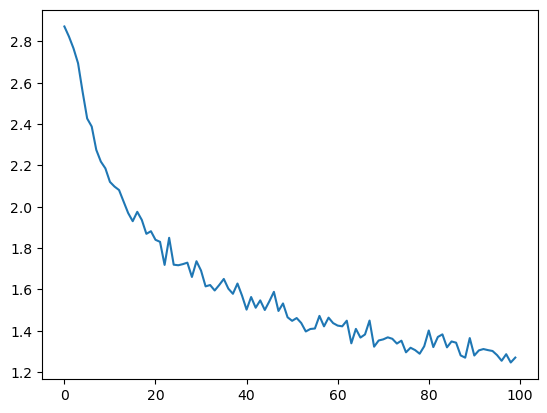

In [34]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

# Evaluating the Results

To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). To calculate the confusion matrix a bunch of samples are run through the network with `evaluate()`, which is the same as `train()` minus the backprop.

C:\Users\66\AppData\Local\Temp\ipykernel_4508\828585331.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\66\AppData\Local\Temp\ipykernel_4508\828585331.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


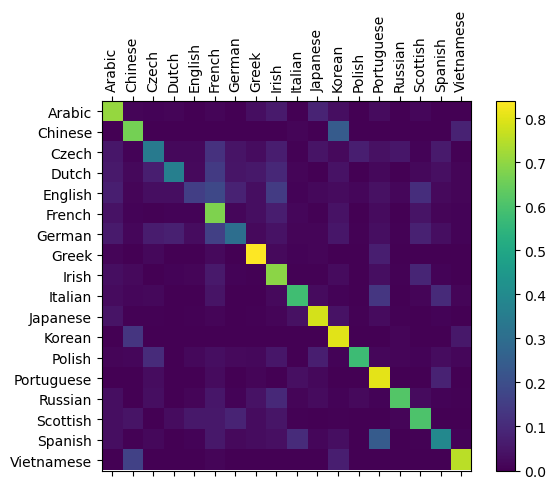

In [35]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_pair()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

You can pick out bright spots off the main axis that show which languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish for Italian. It seems to do very well with Greek, and very poorly with English (perhaps because of overlap with other languages).

# Running on User Input

In [36]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(line_to_tensor(input_line)))

    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Guo')


> Dovesky
(-0.35) Russian
(-1.65) Czech
(-3.59) French

> Jackson
(-0.64) Scottish
(-1.79) English
(-2.02) Russian

> Satoshi
(-0.89) Japanese
(-1.82) Italian
(-2.08) Arabic

> Guo
(-0.23) Chinese
(-2.24) Korean
(-2.71) Vietnamese
